In [85]:
import nasdaqdatalink
import os
import json
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas_market_calendars as mcal
from datetime import datetime
import requests
from refresh_functions import *
pd.options.display.float_format = '{:.6f}'.format

#modelling packages ------
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import xgboost
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

from yellowbrick.regressor import ResidualsPlot
from yellowbrick.target import FeatureCorrelation
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC

import shap

#store my API key
with open('C:/Users/meich/.nasdaq/data_link_apikey.json') as f:
    data=json.load(f)
    key=data['api_key']
quandl.ApiConfig.api_key = key

# Data Refresh & Load
-----
Next step: schedule this code block daily in the cloud (which means having cloud storage for the data also)

In [2]:
%%time

#PRICES 
sharadarSEP()
sep = pd.read_csv('C:/Users/meich/CareerDocs/projects/stock_prediction/Data/SHARADAR_SEP.csv')

#TICKERS + CATEGORIES
tickers = sharadarTICKERS()

#DAILY FUNDAMENTALS
sharadarDAILY()
daily = pd.read_csv('C:/Users/meich/CareerDocs/projects/stock_prediction/Data/SHARADAR_DAILY.csv')
daily['marketcap_max'] = daily.groupby('ticker')['marketcap'].transform(max)
daily = daily[daily['marketcap_max']>=500]
daily['marketcap_total'] = daily.groupby('date')['marketcap'].transform(sum)

#SHORT INTEREST ACTIVITY (FINRA)
finraSHORTS()
si = pd.read_csv('C:/Users/meich/CareerDocs/projects/stock_prediction/Data/FINRA_SI.csv')

#RETAIL TRADER ACTIVITY
nasdaqRTAT()
rtat = pd.read_csv('C:/Users/meich/CareerDocs/projects/stock_prediction/Data/NDAQ_RTAT.csv')

Data up to date
2023-01-10
'sharadarSEP' 0.06 mins
'sharadarTICKERS' 0.54 mins
Data up to date
2023-01-10
'sharadarDAILY' 0.10 mins
Data up to date:
2023-01-10
'finraSHORTS' 0.07 mins
Data up to date:
2023-01-10
'nasdaqRTAT' 0.08 mins
Wall time: 1min 7s


### Create foundational dataset (shar)

In [3]:
combined = daily.merge(tickers,left_on='ticker',right_on='ticker',how='left')
combined = combined.merge(sep,left_on=['date','ticker'],right_on=['date','ticker'],how='left')
combined = combined.merge(rtat,left_on=['date','ticker'],right_on=['date','ticker'],how='left')
combined = combined.merge(si,left_on=['date','ticker'],right_on=['date','ticker'],how='left')
combined.sort_values(['ticker','date'],inplace=True)

# Exploration/Analysis
-----

In [4]:
#ADD PRICE METRICS - logdiff 
    # rdiff 	row-on-row % change	z[t] = (y[t] – y[t-1]) / y[t-1]
    # log returns ln(stock price t1/ stock price t0)
combined = lagged_features(combined)
combined = lagged_features(combined,ft='marketcap_total')

#add price adjusted (market) target variables (closemarket_pctY vs closeadj_pctY)
combined['closemarket_pct1'] = combined['closeadj_pct1'] - combined['marketcap_total_pct1']
combined['closemarket_pct5'] = combined['closeadj_pct5'] - combined['marketcap_total_pct5']
combined['closemarket_pct30'] = combined['closeadj_pct30'] - combined['marketcap_total_pct30']
combined['closemarket_pct90'] = combined['closeadj_pct90'] - combined['marketcap_total_pct90']
combined['closemarket_pct180'] = combined['closeadj_pct180'] - combined['marketcap_total_pct180']
combined['closemarket_pct360'] = combined['closeadj_pct360'] - combined['marketcap_total_pct360']

#CREATE TARGET VARIABLES FOR A SIMPLER PROBLEM -- PREDICT IF NEW PRICE WILL BE HIGHER OR LOWER (RELATIVE TO MARKET)
combined['closemarket_pos1'] = combined['closemarket_pct1'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closemarket_pos5'] = combined['closemarket_pct5'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closemarket_pos30'] = combined['closemarket_pct30'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closemarket_pos90'] = combined['closemarket_pct90'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closemarket_pos180'] = combined['closemarket_pct180'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))
combined['closemarket_pos360'] = combined['closemarket_pct360'].apply(lambda x: 1 if x > 0 else (0 if x<0 else np.nan))

'lagged_features' 0.65 mins
'lagged_features' 0.69 mins


In [5]:
#SI METRICS
combined = short_features(combined)

'short_features' 0.82 mins


In [6]:
#  ---- RTAT NOTES-------#
# CHECK FOR AUTO CORRELATION IN BOTH METRICS
# TEST FOR RMSE STRATEGY OF SIMILARITY INDEX USING ACT/SENT TO PRODUCE A SINGLE SCORE FOR AGG
# SET UP ACTIVITY TRIGGER TO CATCH DAILY VALUES AND SEND NOTIFICATION + VISUAL

combined = rtat_features(combined)

'rtat_features' 0.88 mins


In [11]:
stock = combined[combined['ticker'] == 'GME'].copy()
stock = stock.sort_values(by='date')

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=stock['date'], y=stock['closeadj_lag30'], name="price"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=stock['date'], y=stock['activity'], name="var"),
    secondary_y=True,
)

# fig.add_trace(
#     go.Scatter(x=stock['date'], y=stock['ShortRatio_30'], name="var1"),
#     secondary_y=True,
# )

fig.show()

In [12]:
#Difference between TotalVolume & activity may give insights into non-retail activity
px.scatter(combined[combined['activity']>0.1],
          'TotalVolume','activity')

### Short Term Model (Retail Activity + SI + Price Metrics + [insider / inst. investors])

In [13]:
# BUILD SIMPLE BASELINE MODEL TO PREDICT PRICE AT DIFFERENT TIME POINTS (EX: 5 DAY, 10 DAY, 20 DAY, 1 MONTH, 3 MONTH, 6 MONTH)
#       OR COULD CONSTRUCT AS A CLASSIFICATION MODEL TOO - PREDICT PROBABILITY THAT Y WILL FALL Y%

#do 'reversals' mean anything?? i.e. sentiment / sentiment_5 (or z version)

In [14]:
#px.histogram(combined[combined['ticker']== 'GME']['activity_Z'])

In [88]:
#tesla is the outlier when it comes to activty vs future price
px.scatter(combined[combined['activity']>0.05],
       x='activity',
       y='closemarket_pct90',
           trendline='ols'
      )

# Regression

This is a lot more difficult than predicting direction... and driven somewhat by outliers.. may make sense to clip or quantile bucket

In [192]:
le = preprocessing.LabelEncoder()
combined['sector'] = le.fit_transform(combined['sector'].astype(str))
combined['industry'] = le.fit_transform(combined['industry'].astype(str))

In [15]:
data = combined[combined['activity']>= 0.01 ].copy()
X_train, X_test, y_train, y_test = model_setup(
        data,
     ['activity_30','sentiment_30','ShortRatio_30','TotalVolume_30','evebitda','ps'], 
    'closemarket_pct90')

In [76]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

In [16]:
%%time
#fit and predict 
bst = XGBRegressor(n_estimators=1000
                   ,booster='gblinear'
                  )
bst.fit(X_train,y_train)
predictions = bst.predict(X_test)

Wall time: 288 ms


In [17]:
mean_absolute_error(y_test, predictions)

22.58841058476121

In [18]:
mean_squared_error(y_test, predictions)

1195.6970638196528

In [19]:
r2_score(y_test, predictions)

0.026832134127752427

In [20]:
X_test['preds'] = predictions
X_test['true'] = y_test

In [21]:
X_test['preds'].nunique()

2325

In [22]:
#Inspect predictions vs True Values for pct change in price
px.scatter(X_test,
          'preds',
          'true',
           color='activity_30',
          trendline='ols')

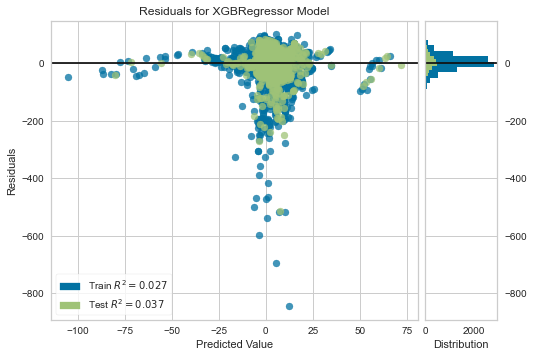

<AxesSubplot:title={'center':'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [23]:
data = combined[combined['activity']>= 0.01 ].copy()
X_train, X_test, y_train, y_test = model_setup(
        data,
     ['activity_30','sentiment_30','ShortRatio_30','TotalVolume_30','evebitda','ps'], 
    'closemarket_pct90')

visualizer = ResidualsPlot(XGBRegressor(n_estimators=1000
                   ,booster='gblinear'
                  ))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

# Classifier

as i increase the rolling timespan, accuracy goes up for 180 prediction -- is this leakage? Model actually seems good (suspicious) - 86% acc, .94 rocauc

    - pos180 vs 30(act,sent,shortratio,totalvolume)
    - when activtiy > 0.01

i bet totalvolume is having some leakage -- not standardized (dropping it does remove about 9 pts of acc)

    - see below about signaling ticker (anyone can predict the ticker from this info, not the task)

does this hold up when I use entire dataset??

When i add evebitda, acc goes wayyy up - has to be leakage (YES - bc evebitda would signal which ticker it is -- need evebitda change maybe)

    - I think the other variables may be signaling the ticker as well

In [194]:
data = combined[combined['activity']>= 0.01 ].copy()
vars = ['activity_15','sentiment_15','ShortRatio_15','TotalVolume_15','evebitda','ps','pb','pe','marketcap','sector','industry']
target = 'closemarket_pos90'

X_train, X_test, y_train, y_test = model_setup(
        data,
     vars, 
    target)

In [195]:
%%time
#fit and predict 
bst = XGBClassifier(n_estimators=100,eval_metric='error',use_label_encoder=False
                  )
bst.fit(X_train,y_train)
predictions = bst.predict(X_test)
probpredictions = bst.predict_proba(X_test)[:,1]

Wall time: 519 ms


In [196]:
y_test.mean()

0.5161013310433663

In [197]:
accuracy_score(y_test,predictions)

0.9021039072563332

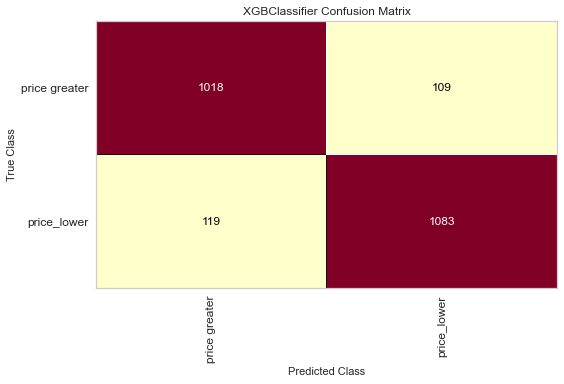

<AxesSubplot:title={'center':'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [198]:
#show classification results in graphs
visualizer = ConfusionMatrix(XGBClassifier(n_estimators=100,eval_metric='error',use_label_encoder=False
                  ),
                            classes=['price greater','price_lower'])

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

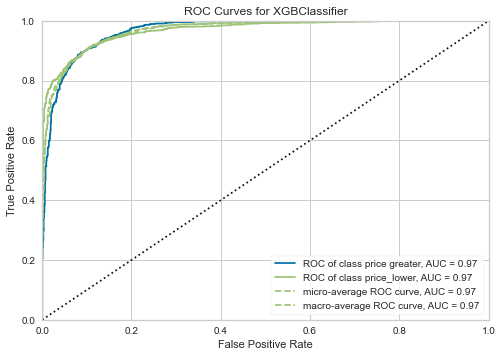

<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [199]:
visualizer = ROCAUC(XGBClassifier(n_estimators=100,eval_metric='error',use_label_encoder=False
                                 ),
                   classes=['price greater','price_lower'])

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

In [200]:
X_test['preds'] = predictions
X_test['proba_preds'] = probpredictions
X_test['true'] = y_test

In [201]:
#shap values or some contribution goal
# what's a good way to look at proba preds vs true class (to see if my probabilities are legit)
X_test['ticker'] = combined['ticker']
X_test['date'] = combined['date']
X_test['market chng'] = combined['closemarket_pct180']
X_test['actual chng'] = combined['closeadj_pct180']
X_test['proba_bins'] =pd.cut(X_test['proba_preds'],10,right=False,labels=False)
X_test['correct'] = X_test['preds'] ==X_test['true']

In [202]:
# actual mean value vs each predicted probability bin - see a linear trend
px.bar(X_test.groupby('proba_bins').mean(),
       x=X_test.groupby('proba_bins').mean().index,
       color='correct',
       y='true')

In [203]:
X_test[X_test['ticker'] =='MSFT']['preds'].mean()

0.5915492957746479

In [204]:
X_test[X_test['ticker'] =='MSFT']['true'].mean()

0.5774647887323944

In [205]:
# predict on newest date
newdata = combined[(combined['date'] == '2023-01-10' ) & (combined['activity']>.01)][vars]
newpreds = bst.predict(newdata)
newproba = bst.predict_proba(newdata)[:,1]

newdata['preds'] = newpreds
newdata['proba_prebs'] = newproba
newdata['ticker'] = combined['ticker']
newdata['date'] = combined['date']
newdata['activity'] = combined['activity']

newdata

activity_15  sentiment_15  ShortRatio_15   TotalVolume_15  evebitda  \
5861201     0.039980     -1.466667       0.474467  37577821.333333 16.300000   
5861012     0.017127     -5.333333       0.423994  27382275.133333 19.000000   
5860973     0.025507     -0.733333       0.385207  32082367.400000 19.900000   
5860771     0.007707     -2.666667       0.493629   9531123.933333 29.900000   
5858867     0.009860     -8.266667       0.362810  10610079.666667  8.300000   
5858746     0.013020     -5.600000       0.344851  10346723.466667 16.500000   
5858653     0.006100     -1.266667       0.588093   3607141.466667  7.400000   
5858555     0.026200     -4.200000       0.449478  22336925.400000 53.800000   
5857483     0.144500     -2.666667       0.491507 109491289.600000 22.200000   

               ps        pb         pe      marketcap  sector  industry  \
5861201  5.300000 41.000000  20.800000 2079668.300000       9        31   
5861012  4.800000  2.000000  48.300000  109720.800000       9       124   
5860973  1.800000  6.700000  81.000000  916822.700000       9        75   
5860771  2.500000  2.300000 160.300000  303915.000000       9        75   
5858867  3.000000  2.800000  12.200000  352629.500000       9        74   
5858746  8.400000  9.800000  24.400000 1705956.200000       9       128   
5858653  4.600000  7.100000  28.900000  145762.000000       2        47   
5858555 13.700000 18.300000  65.700000  391361.400000       9       124   
5857483  5.000000  9.400000  33.500000  375298.900000       2        10   

         preds  proba_prebs ticker        date  activity  
5861201      1     0.988676   AAPL  2023-01-10  0.037100  
5861012      0     0.152281    AMD  2023-01-10  0.015000  
5860973      0     0.121422   AMZN  2023-01-10  0.029200  
5860771      0     0.405353   BABA  2023-01-10  0.015600  
5858867      0     0.366396   META  2023-01-10  0.011500  
5858746      1     0.922989   MSFT  2023-01-10  0.013300  
5858653      0     0.181374   NFLX  2023-01-10  0.012800  
5858555      1     0.527012   NVDA  2023-01-10  0.031300  
5857483      0     0.058101   TSLA  2023-01-10  0.140000

In [154]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_train)

C:\Users\meich\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



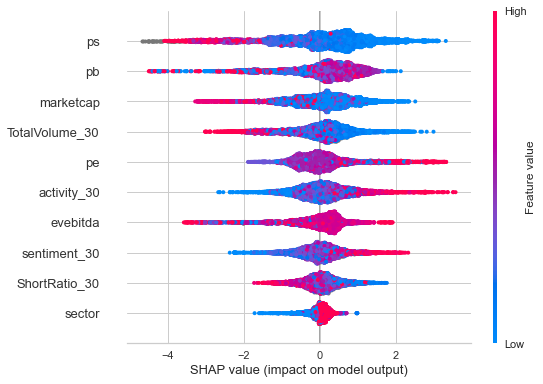

In [155]:
#CLASSIC SHAP SUMMARY PLOT
shap.summary_plot(shap_values, X_train)

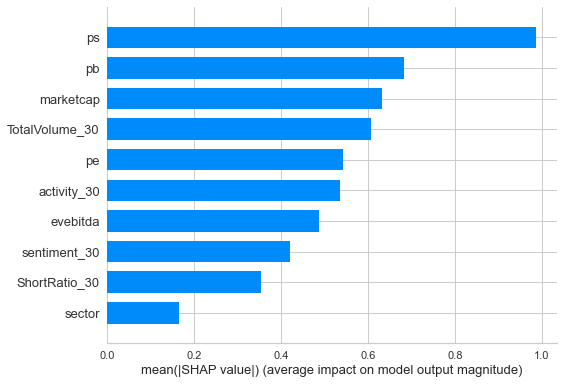

In [156]:
#SHAP FEATURE IMPORTANCE
shap.summary_plot(shap_values, X_train, plot_type="bar")

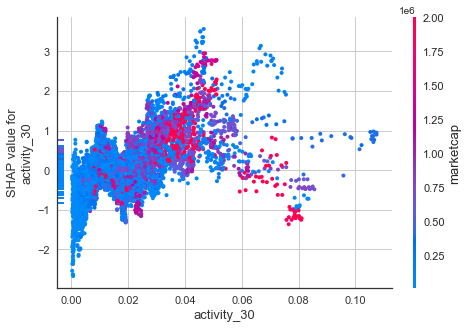

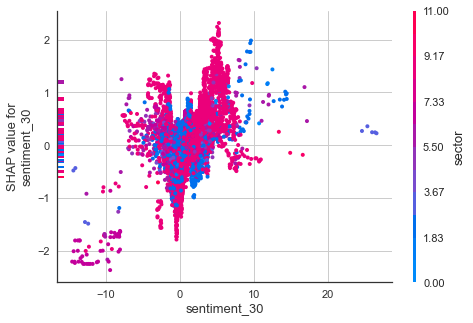

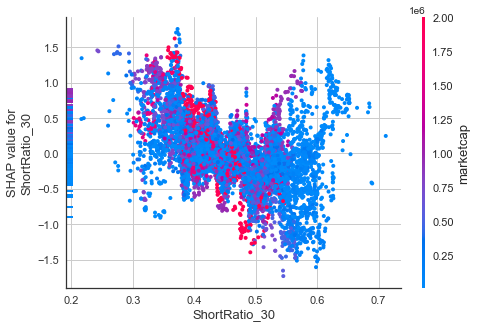

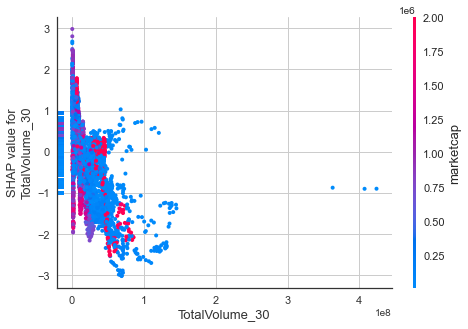

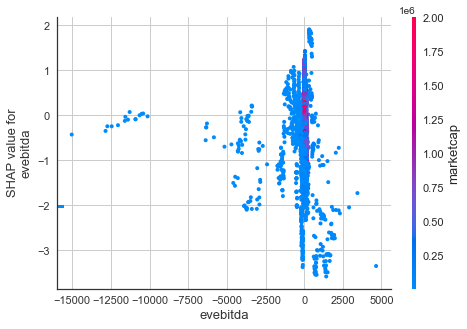

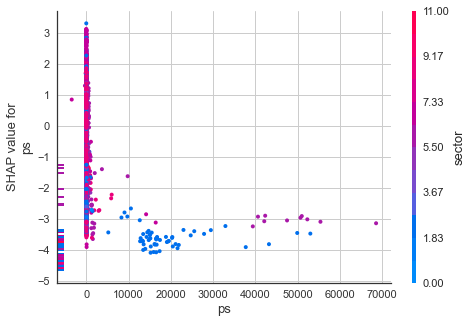

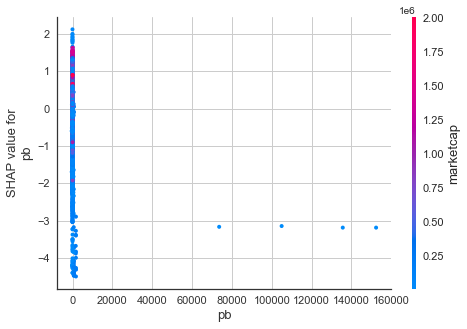

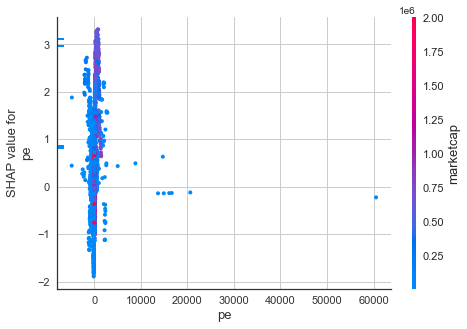

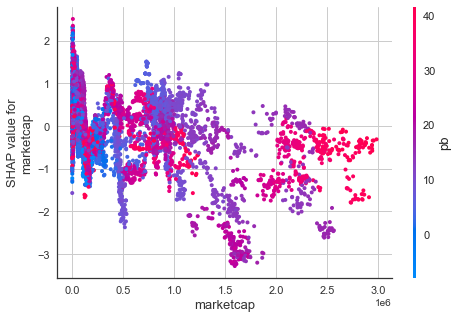

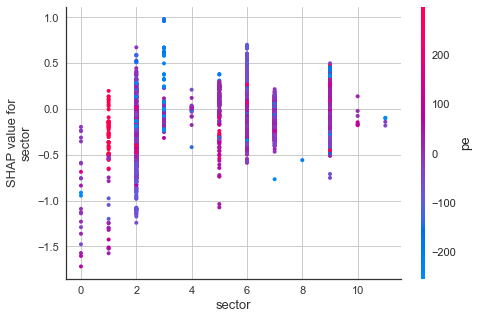

In [157]:
# INTERACTION PLOTS
for name in X_train.columns:
    shap.dependence_plot(name,shap_values,X_train)

# Multi-Classification

Idea is to bucket returns into classes